In [ ]:
import os
from pathlib import Path

import crystal_toolkit  # noqa: F401
from pymatgen.core import Structure

In [ ]:
# Load a structure from a CIF or POSCAR file

batch_name = "bandgap3.5b1"
batch_path = "../output"
cif_name = "gen_0"
cif_path = os.path.abspath(
    os.path.join(batch_path, batch_name, "extracted", f"{cif_name}.cif")
)

print(f"Loading {cif_path}")

struct_expt = Structure.from_file(cif_path)
struct_expt

In [ ]:
# Create output directory based on reduced formula
# get reduced formula

reduced_formula = struct_expt.composition.reduced_formula
print(f"Reduced formula: {reduced_formula}")

output_dir = f"{batch_name}-{cif_name}-{reduced_formula}"

# mkdir in output folder named reduced_formula
os.makedirs(f"output/{output_dir}", exist_ok=True)

## pbe

In [ ]:
# Relax with pbe

import matcalc

calculator_pbe = matcalc.load_fp("pbe")
relax_calc = matcalc.RelaxCalc( # type: ignore
    calculator_pbe,
    optimizer="FIRE",
    relax_atoms=True,
    relax_cell=True
)

data = relax_calc.calc(struct_expt)

final_structure_pbe = data['final_structure']
print(final_structure_pbe)
final_structure_pbe.to(fmt="poscar", filename=f"output/{output_dir}/POSCAR-pbe")

In [ ]:
phonon_calc = matcalc.PhononCalc(  # type: ignore
    calculator_pbe,
    relax_structure=True,
    write_band_structure=f"output/{output_dir}/pbe_phonon_bs.yaml",
    write_total_dos=f"output/{output_dir}/pbe_phonon_dos.dat",
    write_phonon=f"output/{output_dir}/pbe_phonon.yaml",
    optimizer="FIRE",
)

data_phonon_pbe = phonon_calc.calc(final_structure_pbe)

In [ ]:
import matplotlib.pyplot as plt

phonon_bs = data_phonon_pbe["phonon"].band_structure

n_axes = sum(1 for c in phonon_bs.path_connections if not c)

fig, axs = plt.subplots(1, n_axes, figsize=(16, 5))

if n_axes == 1:
    axs = [axs]

for ax in axs[1:]:
    ax.set_ylabel("")
    ax.tick_params(axis="y", labelleft=False)

phonon_bs.plot(ax=axs)
fig.suptitle("Phonon band structure (PBE)", fontsize=16)
plt.subplots_adjust(wspace=0.07)

# Save figure
fig.savefig(f"output/{output_dir}/pbe_phonon_band.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
phonon_dos = data_phonon_pbe["phonon"].total_dos

fig, ax = plt.subplots(figsize=(8, 5))
phonon_dos.plot(ax=ax)
fig.suptitle("Phonon DOS (PBE)", fontsize=16)

# Save figure
fig.savefig(f"output/{output_dir}/pbe_phonon_dos.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    data_phonon_pbe["thermal_properties"]["temperatures"],
    data_phonon_pbe["thermal_properties"]["heat_capacity"],
)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Heat Capacity (J/mol-K)")
ax.set_title("Heat Capacity vs Temperature (PBE)")

# Save figure
fig.savefig(f"output/{output_dir}/pbe_heat_capacity.png", dpi=300, bbox_inches="tight")
plt.show()

## r2scan

In [ ]:
# Relax with r2scan

import matcalc

calculator_r2scan = matcalc.load_fp("r2scan")
relax_calc = matcalc.RelaxCalc( # type: ignore
    calculator_r2scan, optimizer="FIRE", relax_atoms=True, relax_cell=True
)

data_r2scan = relax_calc.calc(struct_expt)

final_structure_r2scan = data_r2scan["final_structure"]
print(final_structure_r2scan)
final_structure_r2scan.to(fmt="poscar", filename=f"output/{output_dir}/POSCAR-r2scan")

In [ ]:
phonon_calc = matcalc.PhononCalc(  # type: ignore
    calculator_r2scan,
    relax_structure=True,
    write_band_structure=f"output/{output_dir}/r2scan_phonon_bs.yaml",
    write_total_dos=f"output/{output_dir}/r2scan_phonon_dos.dat",
    write_phonon=f"output/{output_dir}/r2scan_phonon.yaml",
    optimizer="FIRE",
)

data_phonon_r2scan = phonon_calc.calc(final_structure_r2scan)

In [ ]:
import matplotlib.pyplot as plt

phonon_bs = data_phonon_r2scan["phonon"].band_structure

n_axes = sum(1 for c in phonon_bs.path_connections if not c)

fig, axs = plt.subplots(1, n_axes, figsize=(16, 5))

if n_axes == 1:
    axs = [axs]

for ax in axs[1:]:
    ax.set_ylabel("")
    ax.tick_params(axis="y", labelleft=False)

phonon_bs.plot(ax=axs)
fig.suptitle("Phonon band structure (r2scan)", fontsize=16)
plt.subplots_adjust(wspace=0.07)

# Save figure
fig.savefig(f"output/{output_dir}/r2scan_phonon_band.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
phonon_dos = data_phonon_r2scan["phonon"].total_dos

fig, ax = plt.subplots(figsize=(8, 5))
phonon_dos.plot(ax=ax)
fig.suptitle("Phonon DOS (r2scan)", fontsize=16)

# Save figure
fig.savefig(f"output/{output_dir}/r2scan_phonon_dos.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Heat capacity for r2scan
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    data_phonon_r2scan['thermal_properties']['temperatures'],
    data_phonon_r2scan['thermal_properties']['heat_capacity']
)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel('Heat Capacity (J/mol-K)')
ax.set_title("Heat Capacity vs Temperature (r2scan)")

# Save figure
fig.savefig(f"output/{output_dir}/r2scan_heat_capacity.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure


def plot_phonon_band(band_yaml_file, structure_file, ax=None):
    """
    Plot phonon dispersion directly from band.yaml (even if 'lattice_rec' is missing).
    Imaginary frequencies are shown in red.
    If ax is provided, plot on it; otherwise create a new figure/axes.
    Returns (fig, ax, min_freq).
    """
    try:
        # Load structure if needed (not used directly here, but kept for parity)
        _structure = Structure.from_file(structure_file)

        with open(band_yaml_file, "r") as f:
            data = yaml.safe_load(f)

        q_labels = [p["label"] if "label" in p else "" for p in data.get("labels", [])]
        q_distances = []
        frequencies = []

        # Extract phonon data
        for point in data["phonon"]:
            q_distances.append(point["distance"])
            freqs = [band["frequency"] for band in point["band"]]
            frequencies.append(freqs)

        q_distances = np.array(q_distances)
        frequencies = np.array(frequencies)

        created_fig = None
        if ax is None:
            created_fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

        # Plot
        for i in range(frequencies.shape[1]):
            freq_branch = frequencies[:, i]
            ax.plot(
                q_distances,
                freq_branch,
                color="red" if np.any(freq_branch < 0) else "black",
                lw=1.2,
            )

        ax.axhline(0, color="gray", lw=0.8)
        ax.set_xlabel("Wave vector path")
        ax.set_ylabel("Frequency (THz)")
        ax.set_title("Phonon Band Structure")
        ax.grid(alpha=0.2)

        min_freq = float(np.min(frequencies))
        if min_freq < 0:
            print(
                f"❌ Imaginary frequencies detected (min = {min_freq:.3f} THz). Material unstable."
            )
        else:
            print(
                f"✅ All frequencies positive (min = {min_freq:.3f} THz). Material stable."
            )

        return created_fig, ax, min_freq

    except Exception as e:
        print(f"⚠️ Error while plotting phonon band: {e}")
        return None, None, None


band_file = f"output/{output_dir}/r2scan_phonon_bs.yaml"
structure_file = f"output/{output_dir}/POSCAR_r2scan"

# Use fig/ax and save
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
_, _, min_freq = plot_phonon_band(band_file, structure_file, ax=ax)

# Save figure
fig.savefig(
    f"output/{output_dir}/r2scan_phonon_band_from_yaml.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'output/ferrite-5_POSCAR-0.625-Mn3Zn5(FeO2)16/pbe_phonon_bs.yaml'

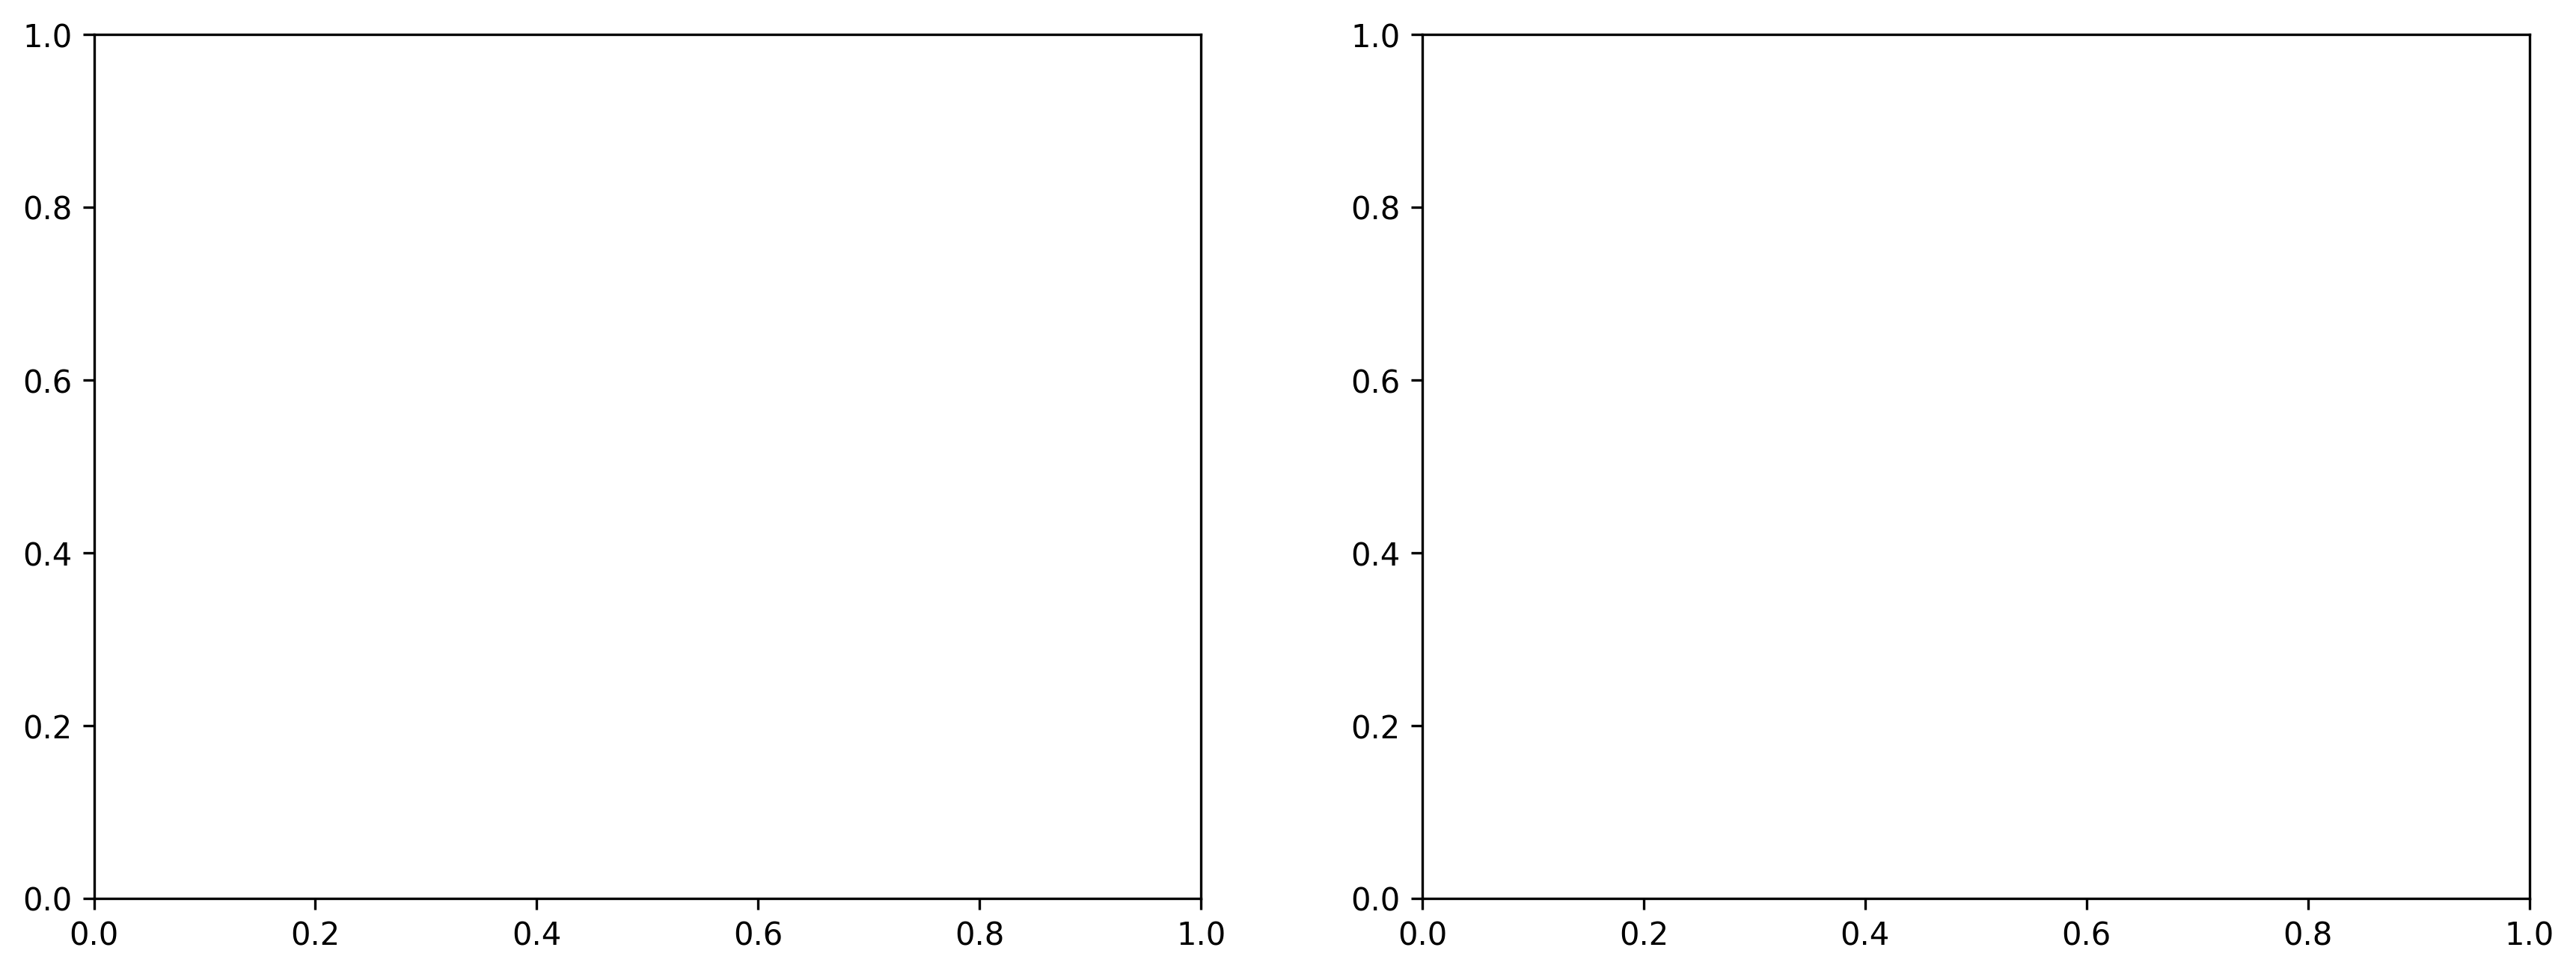

In [19]:
import yaml
import numpy as np
import matplotlib.pyplot as plt


def plot_phonon_band_yaml(ax, band_yaml_file, title=None):
    """
    Plot phonon dispersion directly from band.yaml onto the provided Axes.
    Imaginary frequencies are shown in red.
    Returns the minimum frequency (THz).
    """
    with open(band_yaml_file, "r") as f:
        data = yaml.safe_load(f)

    q_distances = []
    frequencies = []

    for point in data["phonon"]:
        q_distances.append(point["distance"])
        freqs = [band["frequency"] for band in point["band"]]
        frequencies.append(freqs)

    q_distances = np.array(q_distances)
    frequencies = np.array(frequencies)

    for i in range(frequencies.shape[1]):
        freq_branch = frequencies[:, i]
        ax.plot(
            q_distances,
            freq_branch,
            color="red" if np.any(freq_branch < 0) else "black",
            lw=1.2,
        )

    ax.axhline(0, color="gray", lw=0.8)
    ax.set_xlabel("Wave vector path")
    ax.set_ylabel("Frequency (THz)")
    if title:
        ax.set_title(title)
    ax.grid(alpha=0.2)

    return float(np.min(frequencies))


# Paths from earlier blocks
pbe_band_file = f"output/{output_dir}/pbe_phonon_bs.yaml"
r2scan_band_file = f"output/{output_dir}/r2scan_phonon_bs.yaml"

# Side-by-side comparison
fig, axs = plt.subplots(1, 2, figsize=(14, 5), dpi=300)

min_pbe = plot_phonon_band_yaml(
    axs[0], pbe_band_file, title="Phonon Band Structure (PBE)"
)
min_r2 = plot_phonon_band_yaml(
    axs[1], r2scan_band_file, title="Phonon Band Structure (r2scan)"
)

fig.suptitle("Phonon Band Structures from YAML", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save combined figure
fig.savefig(
    f"output/{output_dir}/phonon_band_PBE_vs_r2scan.png", dpi=300, bbox_inches="tight"
)
plt.show()

# Stability messages
print(
    f"PBE min frequency: {min_pbe:.3f} THz -> {'unstable (imaginary)' if min_pbe < 0 else 'stable'}"
)
print(
    f"r2scan min frequency: {min_r2:.3f} THz -> {'unstable (imaginary)' if min_r2 < 0 else 'stable'}"
)